Сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

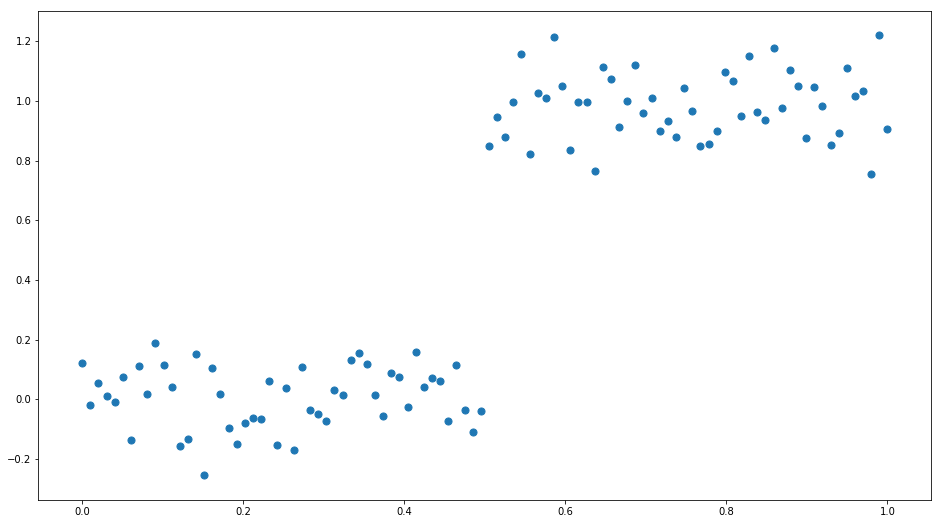

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

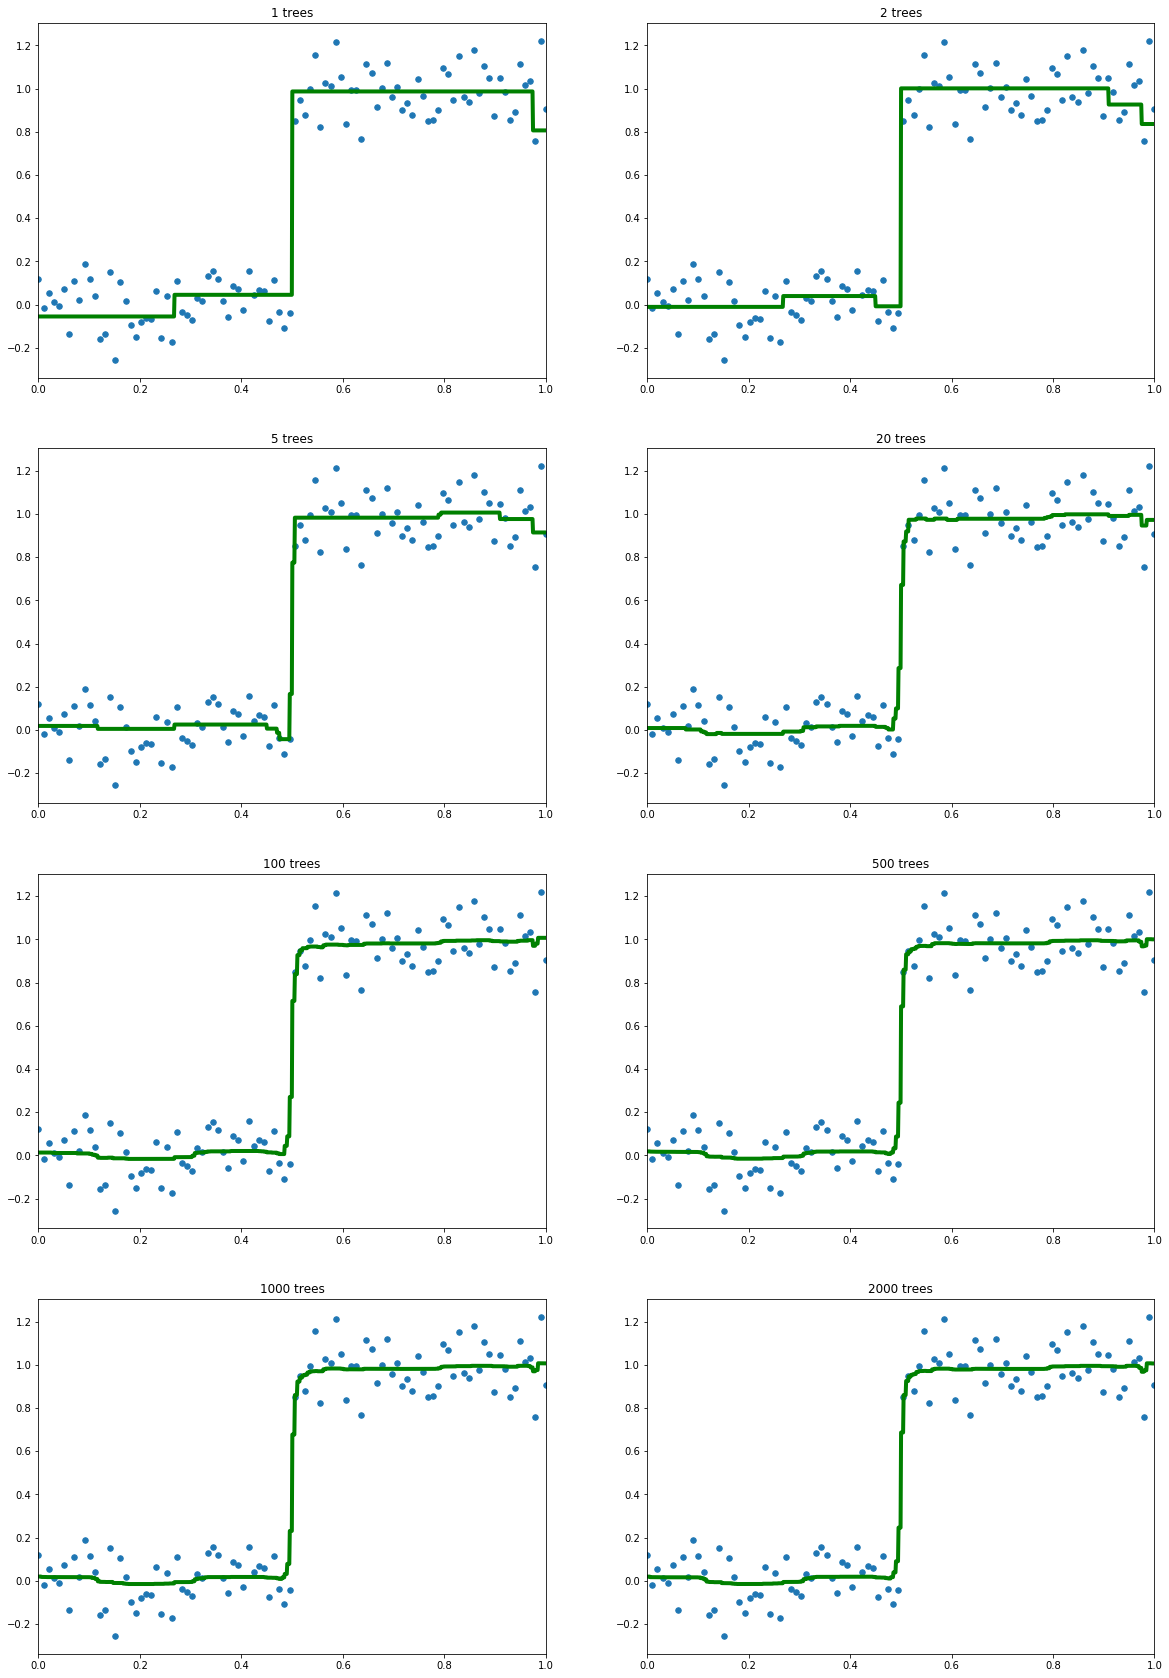

In [4]:
reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)

plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]

for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.title('{} trees'.format(s))
    
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

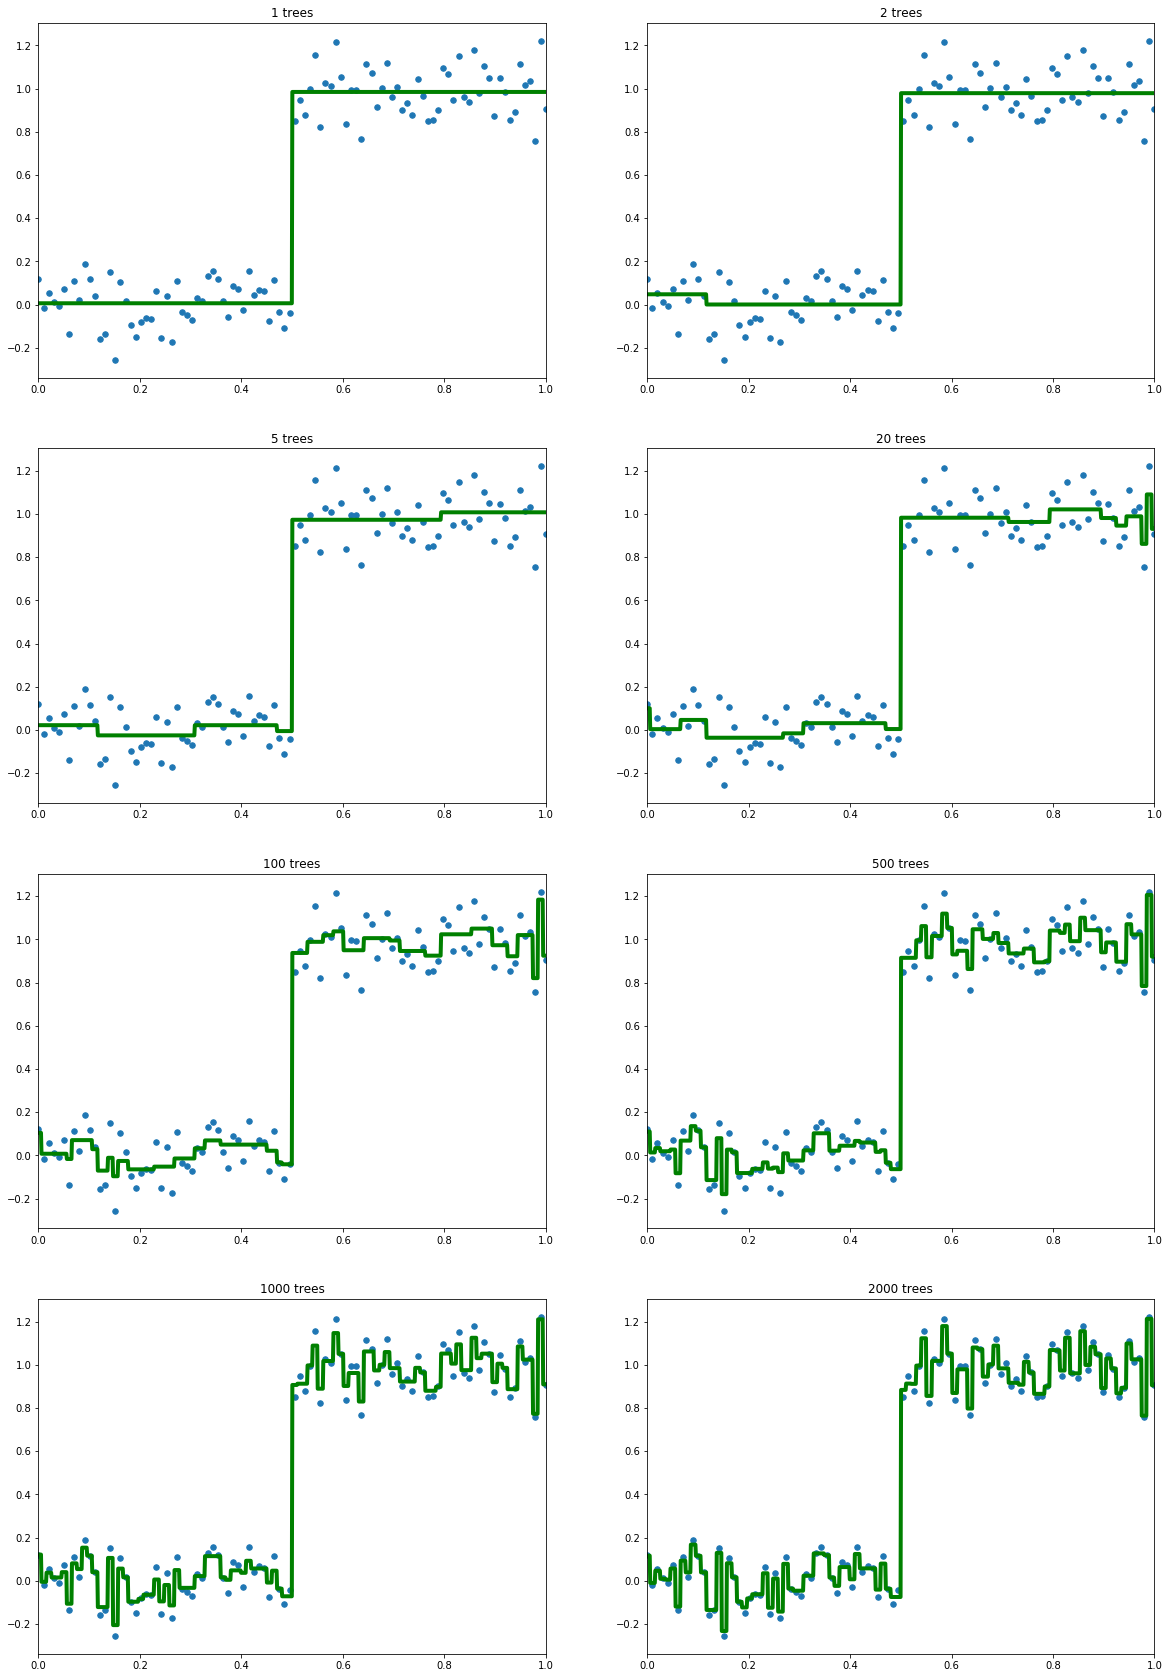

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)

plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]

for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.title('{} trees'.format(s))
        
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего глубоко переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

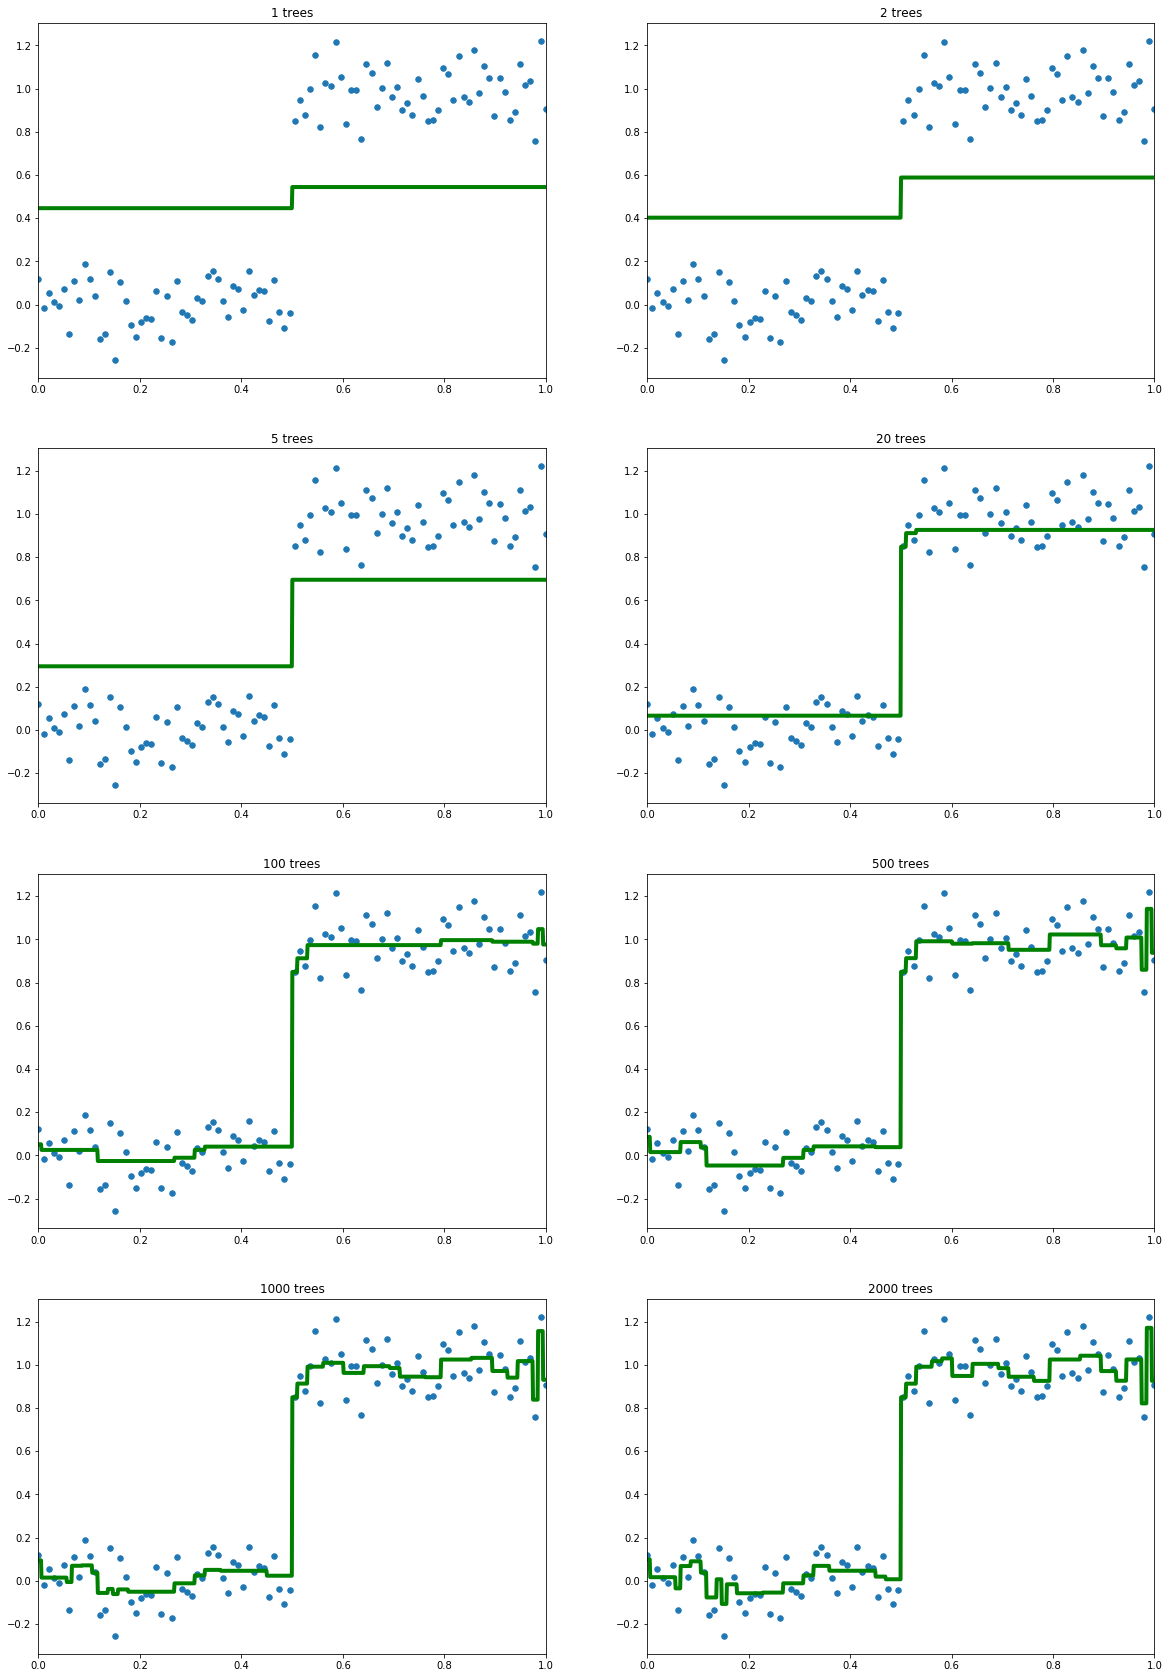

In [6]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)

plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]

for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.title('{} trees'.format(s))
        
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)

Проверим описанный выше эффект на реальных данных:

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [8]:
ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

In [9]:
gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []

for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

In [10]:
gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []

for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

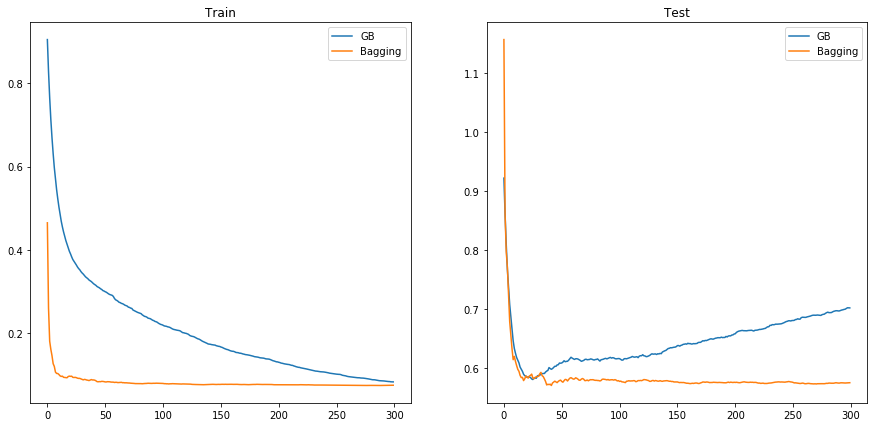

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Train')
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Test')
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()

plt.gcf().set_size_inches(15,7)

---

Сравним поведение градиентного бустинга и случайного леса на примере задачи [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse):

In [12]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [13]:
data = pd.read_csv('train.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [15]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           19.65s
         2           1.1713           19.81s
         3           1.1007           18.42s
         4           1.0524           17.69s
         5           1.0125           16.75s
         6           0.9736           16.21s
         7           0.9441           16.32s
         8           0.9194           16.06s
         9           0.8950           15.75s
        10           0.8786           15.51s
        20           0.7166           13.81s
        30           0.5979           13.35s
        40           0.5150           12.71s
        50           0.4578           12.18s
        60           0.3984           12.12s
        70           0.3420           12.15s
        80           0.3078           11.63s
        90           0.2588           10.70s
       100           0.2241            9.84s
       200           0.0767            3.06s
CPU times: user 14.4 s, sys: 130 ms, total: 14.5 s
Wal

In [16]:
import numpy as np
from sklearn.metrics import roc_auc_score

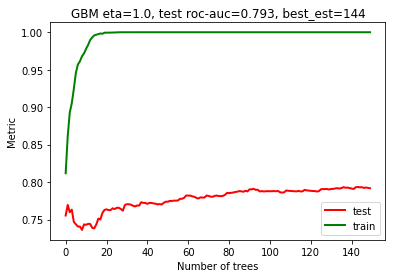

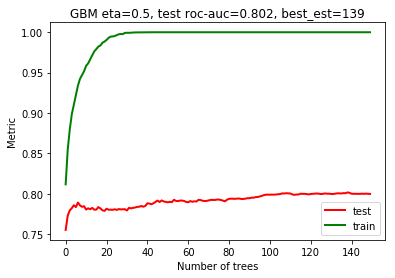

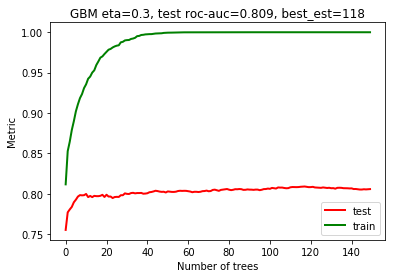

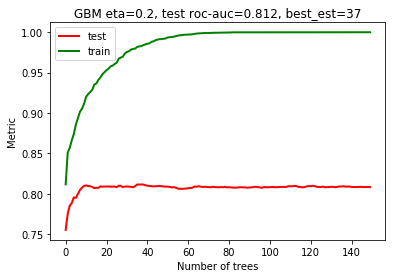

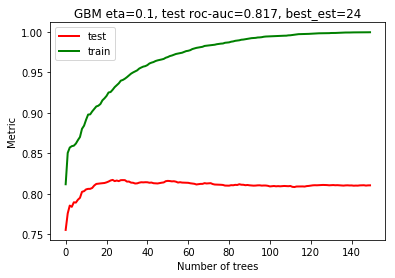

In [17]:
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:
    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    test_deviance = np.zeros(
                            (gbm.n_estimators,), dtype=np.float64
                        )
    for i, y_pred in enumerate( gbm.staged_decision_function(X_test) ):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros(
                            (gbm.n_estimators,), dtype=np.float64
                        )
    for i, y_pred in enumerate( gbm.staged_decision_function(X_train) ):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (
                                                    learning_rate, test_deviance.max(), test_deviance.argmax()+1)
                                                         )
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')
    
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])

Итого, лучшая композиция построена при $\eta = 0.1$, включает 24 базовых алгоритма и достигает значения 0.817 на контрольной выборке. При этом случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [18]:
rf = RandomForestClassifier(n_estimators=24, random_state=0).fit(X_train, y_train)

print ('Train RF ROC-AUC =', roc_auc_score( y_train, rf.predict_proba(X_train)[:,1] ))
print ('Test RF ROC-AUC = ', roc_auc_score( y_test, rf.predict_proba(X_test)[:,1] ))

Train RF ROC-AUC = 0.9999786482947104
Test RF ROC-AUC =  0.8037501166053144


Заметим также, что при всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, требующие вычислительных мощностей для их обучения.

Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [19]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    
    print (n_estimators, 'trees: train ROC-AUC =',  roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]
                                                    ), 
                           'test ROC-AUC =',  roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
              )

10 trees: train ROC-AUC = 0.9989608836759096 test ROC-AUC = 0.784906473568266
20 trees: train ROC-AUC = 0.9999786482947105 test ROC-AUC = 0.8127159440725036
30 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8058969998349587
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.810904749603542
50 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8183836350720083
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8193794893046017
70 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8185867974081328
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8157335550628234
90 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8282284872164697
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8249590535953902


Допустим, обучающая выборка была получена из отрезка $[0; 10],$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim p(\varepsilon) = \mathcal{N} (0, \sigma^2).$

Обучим линейную модель и решающее дерево и построим прогнозы для этого отрезка:

In [20]:
from numpy.random import rand, randn

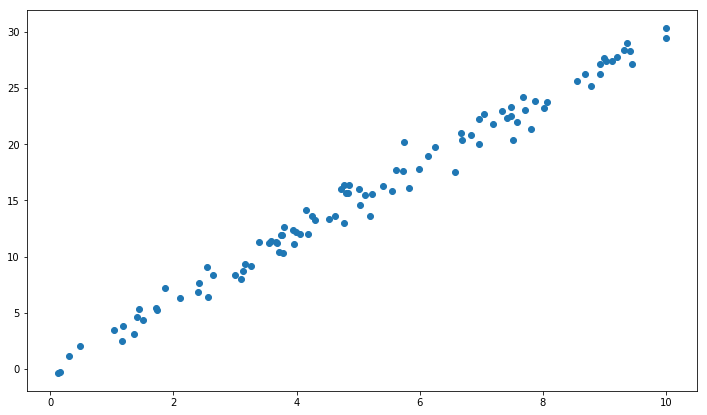

In [21]:
set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * 3 + sigma * randn(set_size).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [23]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)

DecisionTreeRegressor()

LR train MSE =  0.8794372468361438
DT train MSE =  0.0


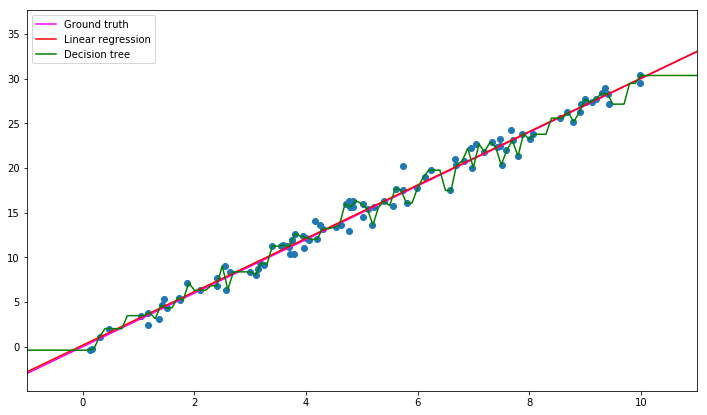

In [24]:
grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.xlim([-1, 11])

plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')

plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)

print ('LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train)))
print ('DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train)))

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$ В этом случае предсказания линейной регрессии окажутся гораздо ближе к правде, что отразится и на значении функционала ошибки:

In [25]:
X_test = (20 + rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * randn(set_size).reshape(-1, 1)

LR test MSE =  0.8134578431493624
DT test MSE =  2003.0515614800552


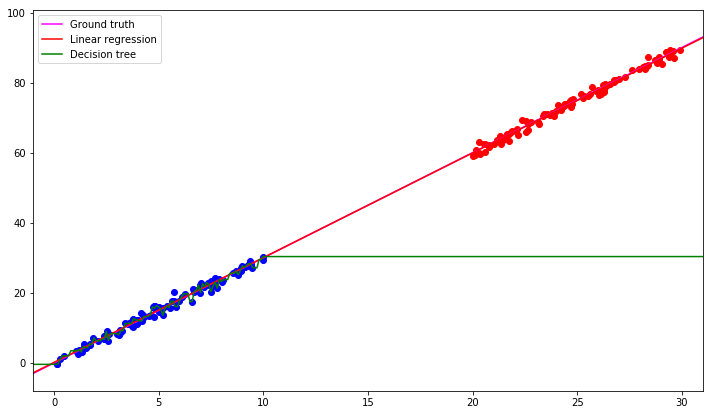

In [26]:
grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.xlim([-1, 31])

plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')

plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)

print ('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print ('DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test)))

**Вывод**: решающие деревья (а потому и композиции над ними, в т.ч. градиентный бустинг) непригодны для экстраполяции функций.

В качестве решения этой проблемы в некоторых случаях можно использовать [нормализацию](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization).